# Сжатие языковой модели

## Порядок сдачи домашнего

Вам требуется создать гит репозиторий куда вы будете складывать все ваши домашние. Под каждое домашнее вы создаете отдельную ветку куда вносите все изменения в рамках домашнего. Как только домашнее готово - создаете пулл реквест (обратите внимание что в пулл реквесте должны быть отражены все изменения в рамках домашнего). Ревьювером назначаете http://github.com/michael15346/ и https://github.com/shgpavel . Перед сдачей проверьте код, напишите тесты. Не забудьте про PEP8, например, с помощью flake8. Задание нужно делать в jupyter notebook.

**Дедлайн - 13 ноября 00:00**

В этом домашнем задании вам предстоит изучить и реализовать комбинированный алгоритм для сжатия матриц весов языковой модели, который включает три этапа: 
- **Квантизацию**
- **Кодирование Хаффмана**
- **Бит-паккинг**
- **Запись и чтение в файл**

Вам также необходимо будет реализовать обратную процедуру расжатия для восстановления матрицы до её исходного состояния. Пакетом `numpy` пользоваться нельзя.

Для начала сгенерируем нашу матрицу весов. Реализуйте функцию `generate_normal_weights_matrix`, которая будет генерировать матрицу случайных весов, где веса распределены нормально. Вам понадобится функция `random.gauss` для генерации случайных чисел из нормального распределения:

In [875]:
import random

mean = 0.0
stddev = 0.1
random.gauss(mean, stddev)

-0.01852080343684308

```python
weights_matrix = generate_normal_weights_matrix(5, 5)
for row in weights_matrix:
    print(row)
[0.3000485326712691, 0.25965299191334695, -0.06755153631842248, 0.13020487844655038, 0.1143769419370928]
[0.04287032494033407, 0.37860865986969466, -0.21154587156719093, 0.02538857794887883, 0.358874552698265]
[-0.12730102686770312, -0.09250783210681686, -0.31943991155969786, -0.12649930568136855, -0.133368865014227]
[-0.001125940850390421, 0.08131363950833258, -0.12099869191945688, 0.14554258117597563, 0.157276907472140]
[-0.07352639207896368, 0.013629438616873364, -0.11502982664385775, 0.042140678513802377, 0.0980238501942050]
```

In [876]:
def generate_normal_weights_matrix(rows, cols, mean=0.0, stddev=0.1):
    result = [[0] * cols] * rows
    for i in range(rows):
        for j in range(cols):
            result[i][j] = random.gauss(mean, stddev)

    return result

Для упрощения работы переведем двух мерный массив в одномерный.

In [877]:
weights_matrix = generate_normal_weights_matrix(100, 100, mean, stddev)

In [878]:
weights = [weight for row in weights_matrix for weight in row]

Проверим, что у нас получилось.

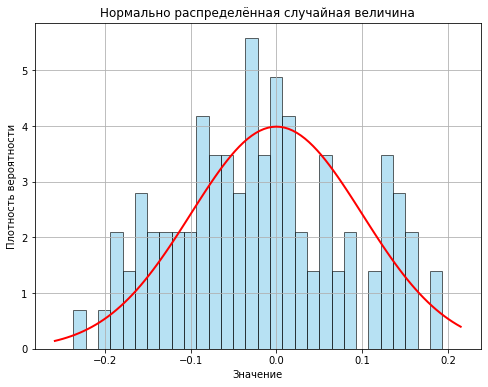

In [879]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(weights, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Добавление кривой плотности вероятности
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, stddev)  # Вычисление плотности вероятности
plt.plot(x, p, 'r', linewidth=2)

# Настройки графика
plt.title("Нормально распределённая случайная величина")
plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.grid(True)

# Отображение графика
plt.show()

Приступим к сжатию этой матрицы!

## Квантизация

**Квантизация** — это процесс преобразования данных с высокой точностью (например, с 32-битного представления) в данные с более низкой точностью (например, 8-битное представление) для уменьшения объёма памяти и вычислительных ресурсов. В контексте машинного обучения, квантизация чаще всего применяется к весам нейронных сетей и их активациям для уменьшения размера модели и ускорения работы, особенно при выполнении инференса на мобильных устройствах и встраиваемых системах.


### Цели квантизации:

1.	**Уменьшение объёма памяти:** Квантизация позволяет сократить объём памяти, занимаемый весами и другими параметрами модели, путём представления чисел с меньшей разрядностью.
2.	**Ускорение вычислений:** С помощью квантизации можно использовать специальные процессоры и ускорители (например, процессоры с поддержкой 8-битных вычислений), что увеличивает производительность.
3.	**Снижение энергопотребления:** Более короткие представления данных позволяют сократить энергопотребление при выполнении операций.

### Как работает квантизация?

Квантизация заключается в преобразовании значений с высокой точностью (например, числа с плавающей точкой) в числа с меньшей точностью (например, целые числа). Существует несколько методов квантизации:

1.	**Униформная (равномерная) квантизация:** Простая и часто используемая техника, когда диапазон значений разделяется на равные интервалы (кванты), и каждое значение округляется до ближайшего значения из этого интервала.
2.	**Неравномерная квантизация:** Применяется, когда диапазон значений распределён неравномерно, и поэтому используются интервалы с разной шириной.
3.	**Квантизация во время обучения (quantization-aware training):** Модель обучается с учётом того, что её веса будут квантизированы. Это позволяет лучше подготовить модель к работе в условиях низкой точности.
4.	**Квантизация после обучения (post-training quantization):** Модель сначала обучается с полной точностью, а затем веса и активации квантизируются.

В данном домашнем задании мы рассмотри наиболее простой вариант - **равномерная квантизация**.

### Пример униформной квантизации

Предположим, у нас есть матрица весов, представленная в виде чисел с плавающей точкой, и мы хотим сократить количество бит, используемых для хранения этих значений.

#### Шаг 1: Определение диапазона значений

Для начала определим минимальное и максимальное значение весов, чтобы определить диапазон:

In [880]:
min_value = min(weights)
max_value = max(weights)

print(f"Минимальное значение: {min_value}")
print(f"Максимальное значение: {max_value}")

Минимальное значение: -0.236881565935742
Максимальное значение: 0.19337180328598008


#### Шаг 2: Определение шага квантизации

Теперь мы определим шаг квантизации, который будет разделять диапазон на равные интервалы. Предположим, что мы хотим использовать 8-битное представление. Это даёт нам $256$ различных значений (так как $8$ бит позволяют хранить $2^8 = 256$ различных чисел).

Шаг квантизации можно вычислить как:


$$\text{step} = \frac{\max - \min}{2^8 - 1}$$


In [881]:
num_levels = 256  # Для 8 бит
step = (max_value - min_value) / (num_levels - 1)
print(f"Шаг квантизации: {step}")

Шаг квантизации: 0.0016872681145949885


#### Шаг 3: Применение квантизации

Теперь мы можем преобразовать каждое значение в его ближайший квантизированный уровень:


$$\text{quantized\_value} = \text{round} \left( \frac{\text{value} - \min}{\text{step}} \right)$$


In [882]:
quantized_weights = [round((weight - min_value) / step) for weight in weights]

print("Квантизированные веса:")
print(set(quantized_weights))

Квантизированные веса:
{0, 17, 30, 33, 38, 40, 43, 45, 48, 50, 54, 56, 57, 64, 66, 68, 69, 70, 73, 77, 79, 86, 88, 90, 92, 93, 95, 96, 97, 100, 101, 103, 104, 107, 110, 111, 112, 116, 122, 123, 124, 125, 127, 128, 129, 132, 133, 135, 138, 140, 141, 142, 143, 144, 145, 149, 150, 151, 153, 154, 156, 164, 166, 173, 175, 177, 183, 185, 187, 193, 207, 210, 213, 214, 215, 219, 220, 222, 226, 227, 229, 231, 232, 234, 247, 255}


#### Шаг 4: Обратное преобразование (деквантизация)

Чтобы восстановить оригинальные значения весов, необходимо преобразовать квантизированные значения обратно в их исходный диапазон:


$$\text{recovered\_value} = \text{quantized\_value} \times \text{step} + \min$$


In [883]:
recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]

print("Восстановленные веса:")
print(recovered_weights[:5])

Восстановленные веса:
[-0.11371099357030784, 0.12250654247299053, 0.13263015116056048, -0.0614056820178632, 0.022957723711886202]


Посчитаем максимальную ошибку

In [884]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.0008387608150198372

На практике намного удобнее, когда мы можем контролировать ошибку, поэтому реализуйте методы квантизации и деквантизации, у которых будет параметр максимальной возможной ошибки между значениями для задания `step`.

In [885]:
def quantize_weights(weights, max_error):
    min_value = min(weights)
    step = max_error * 2
    result = [round((value - min_value) / step) for value in weights]
    return result, step, min_value

def dequantize_weights(quantized_weights, step, min_value):
    return [weight * step + min_value for weight in quantized_weights]

In [886]:
max_error = 0.01
quantized_weights, step, min_value = quantize_weights(weights, max_error)
recovered_weights = dequantize_weights(quantized_weights, step, min_value)

print(quantized_weights)
print(recovered_weights)
print("error:", max([abs(w - rw) for w, rw in zip(weights, recovered_weights)]))

[6, 18, 18, 9, 13, 6, 4, 8, 3, 5, 7, 13, 13, 11, 6, 12, 20, 10, 12, 7, 5, 4, 11, 9, 19, 5, 11, 0, 12, 15, 5, 10, 11, 16, 8, 6, 19, 13, 20, 9, 8, 8, 15, 8, 9, 13, 10, 3, 4, 13, 10, 11, 18, 7, 3, 3, 22, 9, 18, 9, 9, 6, 11, 11, 6, 8, 7, 13, 17, 11, 16, 19, 4, 16, 1, 12, 8, 12, 3, 10, 14, 19, 12, 6, 15, 16, 12, 21, 19, 9, 15, 8, 15, 15, 14, 19, 13, 12, 11, 18, 6, 18, 18, 9, 13, 6, 4, 8, 3, 5, 7, 13, 13, 11, 6, 12, 20, 10, 12, 7, 5, 4, 11, 9, 19, 5, 11, 0, 12, 15, 5, 10, 11, 16, 8, 6, 19, 13, 20, 9, 8, 8, 15, 8, 9, 13, 10, 3, 4, 13, 10, 11, 18, 7, 3, 3, 22, 9, 18, 9, 9, 6, 11, 11, 6, 8, 7, 13, 17, 11, 16, 19, 4, 16, 1, 12, 8, 12, 3, 10, 14, 19, 12, 6, 15, 16, 12, 21, 19, 9, 15, 8, 15, 15, 14, 19, 13, 12, 11, 18, 6, 18, 18, 9, 13, 6, 4, 8, 3, 5, 7, 13, 13, 11, 6, 12, 20, 10, 12, 7, 5, 4, 11, 9, 19, 5, 11, 0, 12, 15, 5, 10, 11, 16, 8, 6, 19, 13, 20, 9, 8, 8, 15, 8, 9, 13, 10, 3, 4, 13, 10, 11, 18, 7, 3, 3, 22, 9, 18, 9, 9, 6, 11, 11, 6, 8, 7, 13, 17, 11, 16, 19, 4, 16, 1, 12, 8, 12, 3, 10, 14

## Кодирование Хаффмана

**Кодирование Хаффмана** — это алгоритм сжатия данных, который используется для минимизации количества бит, необходимых для представления данных. Алгоритм Хаффмана является типом префиксного кодирования, где каждому символу данных назначается уникальная двоичная строка (код), и никакой код не является префиксом другого кода.

Этот метод особенно полезен, когда некоторые символы встречаются чаще других. Хаффмановское кодирование назначает более короткие коды для часто встречающихся символов и более длинные коды для редких символов, что позволяет сжимать данные без потерь.

Основные характеристики кодирования Хаффмана:

- **Префиксный код:** никакой код не является префиксом другого кода, что позволяет однозначно декодировать последовательность.
- **Оптимальность:** алгоритм Хаффмана даёт минимальную длину кодов для символов при известной частоте их появления.
- **Дерево Хаффмана:** строится на основе частот символов, где часто встречающиеся символы находятся ближе к корню дерева.


### Этапы работы алгоритма Хаффмана:

1.	**Подсчёт частот:** На первом шаге подсчитывается, как часто каждый символ встречается в данных.
2.	**Построение дерева Хаффмана:** Используя частоты символов, строится бинарное дерево. Символы с меньшими частотами располагаются дальше от корня дерева, а символы с более высокими частотами — ближе.
3.	**Назначение кодов:** Проходя от корня дерева к каждому листу (символу), алгоритм назначает каждому символу код: левой ветви присваивается “0”, а правой ветви — “1”. Таким образом, для каждого символа формируется уникальная двоичная строка.
4.	**Сжатие данных:** После того как к каждому символу присвоен код, данные можно сжать, заменив символы на соответствующие двоичные коды.
5.	**Декодирование:** Для восстановления исходных данных декодирование выполняется путём чтения двоичной строки и перемещения по дереву Хаффмана от корня до символа, который закодирован.

### Пример работы алгоритма Хаффмана

Рассмотрим, как кодирование Хаффмана может быть применено к строке “ABRACADABRA”.

**1.	Частоты символов:**
Подсчитаем частоты каждого символа в строке:
```python
A: 5
B: 2
R: 2
C: 1
D: 1
```

**2. Построение дерева Хаффмана:**
- Начнем с того, что каждый символ представляется в виде узла дерева с весом, равным частоте появления символа.
- На каждом шаге выбираются два узла с наименьшими частотами и объединяются в новый узел, вес которого равен сумме частот двух выбранных узлов. Этот процесс повторяется до тех пор, пока не будет построено одно дерево.

Строим дерево Хаффмана:
```python
Шаг 1:   C:1  D:1 -> 2 (левое поддерево: C, правое поддерево: D)
Шаг 2:   B:2  R:2 -> 4 (левое поддерево: B, правое поддерево: R)
Шаг 3:   2 (CD)  4 (BR) -> 6
Шаг 4:   A:5  6 (CD, BR) -> 11
```

Окончательное дерево Хаффмана выглядит следующим образом:

```python
      11
     /  \
    A    6
        /  \
      CD    BR
      / \   / \
     C   D B   R
```

**3.	Назначение кодов:**
Теперь присвоим каждому символу код, начиная от корня дерева:
- A: 0
- C: 100
- D: 101
- B: 110
- R: 111

**4. Сжатие строки:**
Используя полученные коды, мы можем закодировать строку “ABRACADABRA”:
```python
A -> 0
B -> 110
R -> 111
A -> 0
C -> 100
A -> 0
D -> 101
A -> 0
B -> 110
R -> 111
A -> 0
```

Закодированная строка: 0110111001000101101110

Реализуйте методы `huffman_encode` и `huffman_decode` для кодирования и декодирования с помощью алгоритма Хаффмана.

In [887]:
import heapq
from collections import Counter, namedtuple

class HuffmanNode(namedtuple("HuffmanNode", ["value", "freq"])):
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = Counter(data)
    
    heap = [HuffmanNode(value, freq) for value, freq in freq.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    
    return heap[0]

def build_codes(node, prefix="", code_map={}):
    if node.value is not None:
        code_map[node.value] = prefix
    else:
        build_codes(node.left, prefix + "0", code_map)
        build_codes(node.right, prefix + "1", code_map)
    return code_map

def huffman_encode(data):
    root = build_huffman_tree(data)
    code_map = build_codes(root)
    encoded_data = "".join(code_map[value] for value in data)
    return encoded_data, code_map

def huffman_decode(encoded_data, code_map):
    reverse_code_map = {code: value for value, code in code_map.items()}
    
    decoded_data = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_code_map:
            decoded_data.append(reverse_code_map[buffer])
            buffer = ""
    return decoded_data


#### Посчитаем код Хаффмана на наших квантизированных весах

In [888]:
encoded_data, huffman_dict = huffman_encode(quantized_weights)
decoded_data = huffman_decode(encoded_data, huffman_dict)

## Бит пакинг

**Бит-паккинг (bit-packing)** — это техника сжатия данных, при которой несколько чисел или символов, представленных в виде бит, “упаковываются” в одно или несколько целых чисел (байтов или слов) с целью минимизировать занимаемую память. Этот метод особенно эффективен, если числа или коды занимают меньше бит, чем стандартный размер ячейки памяти (например, 8 бит для байта или 32 бит для целого числа).


### Основная идея:

Если каждая единица данных (например, число или символ) требует меньше бит, чем стандартная ячейка памяти, можно “упаковать” несколько таких единиц данных в одну ячейку, чтобы избежать потерь памяти на неиспользуемые биты. Это позволяет эффективно использовать пространство памяти и уменьшить общий объём данных.

### Пример использования бит-паккинга после кодирования Хаффмана

После кодирования Хаффмана символы данных преобразуются в коды разной длины (в битах). Например, для часто встречающихся символов коды будут короткими (например, 2 или 3 бита), а для редких символов — длинными (например, 6 или 7 бит). Однако стандартные структуры данных Python (например, массивы байтов) используют 8-битные ячейки памяти, что может привести к неэффективному использованию памяти, если не применить бит-паккинг.

### Почему бит-паккинг полезен после кодирования Хаффмана?

После кодирования Хаффмана мы получаем строку из 0 и 1 разной длины для каждого символа. Например:
```python
A -> 0
B -> 110
C -> 1001
```

Закодированная строка после Хаффмана может выглядеть так: 011011001. Если мы будем хранить эту строку побитно в стандартных байтах, это может занять больше места, чем нужно, так как каждый символ по умолчанию занимает 8 бит. Однако с помощью бит-паккинга можно эффективно “упаковать” эти коды в минимально возможное количество байтов.

### Пример

Предположим, у нас есть коды:

```python
A -> 0 (1 бит)
B -> 110 (3 бита)
C -> 1001 (4 бита)
```

После кодирования строки “AABAC”, мы получаем последовательность бит: 0110110011001. Данная строка может быть запакована в 2 байта:
- В первом байте хранится значение 01101101 (первые 8 бит).
- Во втором байте хранится значение 10011000 (оставшиеся 5 бит и заполненные нулями).

Реализуйте функцию `bit_packing`, которая упаковывает входную битовую строку в набор байт.

```python
encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
Упакованные данные: b'l\xc8'
print(f"Длина упакованных данных: {len(packed_data)} байт")
Длина упакованных данных: 2 байт
```

In [889]:
def bit_packing(bit_string):
    if len(bit_string) % 8:
        bit_string += '0' * (8 - (len(bit_string) % 8))
    n = len(bit_string) // 8
    number = int(bit_string, 2)
    packed_string = number.to_bytes(n, 'little')
    return packed_string

encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)
print(packed_data)
print(len(packed_data))

b'\xc8l'
2


Реализуйте функцию `bit_unpacking`, которая распаковывет набор байт в битовую строку.
```python
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")
Распакованные данные: 0110110011001000
```

In [890]:
def bit_unpacking(packed_data):
    packed_data = packed_data
    bits = [format(byte, '08b') for byte in packed_data]
    return ''.join(bits)

unpacked_data = bit_unpacking(packed_data)
print(unpacked_data)

1100100001101100


## Запись и чтение в файл

Работа с файлами в бинарном режиме в Python позволяет читать и записывать байты вместо текста. Это полезно для работы с бинарными данными, такими как изображения, аудиофайлы, видео, архивы и другие типы файлов, где данные представлены не в текстовом виде, а в виде байтов.

### Открытие файлов в бинарном режиме

Для открытия файла в бинарном режиме используются следующие режимы:

- 'rb' — открыть файл для чтения в бинарном режиме.
- 'wb' — открыть файл для записи в бинарном режиме (при этом файл перезаписывается).
- 'ab' — открыть файл для добавления в бинарном режиме.
- 'rb+' или 'wb+' — открыть файл для чтения и записи в бинарном режиме.

### Кодирование и декодирование
Когда вы открываете файл в бинарном режиме ('wb' или 'rb'), данные в этом файле хранятся и читаются в виде байтов. Символы в строках Python (тип str) не могут быть напрямую записаны в файл, потому что они хранятся в формате Unicode (например, UTF-8, UTF-16), а файлы оперируют байтовыми данными.

- `encode()`: Преобразует строку Unicode в байты с использованием заданной кодировки (по умолчанию обычно UTF-8). Это нужно для записи текста в файл.
- `decode()`: Преобразует байты обратно в строку Unicode, чтобы можно было прочитать текст из файла.

Обратите внимание, что `packed_data` уже байты и их можно без кодирования и декодирования записывать в файл.


### Пример 1: Запись в файл в бинарном режиме

In [891]:
with open('output.bin', 'wb') as f:
    f.write(f"{step:.6f}\n".encode())

### Пример 2: Чтение файла в бинарном режиме

In [892]:
# Открываем файл для чтения в бинарном режиме
with open('output.bin', 'rb') as f:
    step = float(f.readline().strip())
    print(step)

0.02


Реализуйте функцию `write_to_file` для сохранения матрицы в сжатом формате

In [ ]:
import pickle
def write_to_file(filename, packed_data, huffman_dict, step, min_value):
    with open(filename, 'wb') as f:
        pickle.dump(step, f)
        pickle.dump(huffman_dict, f)
        pickle.dump(min_value, f)
        pickle.dump(packed_data, f)

#### Сохраним в файл сжатую матрицу и параметры для восстановления

In [894]:
compresed_filename = 'compressed_data.bin'

In [895]:
encoded_data, huffman_dict = huffman_encode(quantized_weights)
packed_data = bit_packing(encoded_data)
write_to_file(compresed_filename, packed_data, huffman_dict, step, min_value)

Реализуйте функцию `read_from_file` для чтения матрицы и сохраненной информации необходимой для восстановления матрицы.

In [896]:
def read_from_file(filename):
    with open(filename, 'rb') as f:
        step = pickle.load(f)
        huffman_dict = pickle.load(f)
        min_value = pickle.load(f)
        packed_data = pickle.load(f)
        return packed_data, huffman_dict, step, min_value

#### Прочитаем файл и восстановим данные

In [897]:
packed_data, huffman_dict, step, min_value = read_from_file(compresed_filename)
unpacked_bits = bit_unpacking(packed_data)
decoded_weights = huffman_decode(unpacked_bits, huffman_dict)
recovered_weights = dequantize_weights(decoded_weights, step, min_value)

print(recovered_weights)

[0.12311843406425799, -0.016881565935742, 0.16311843406425802, -0.016881565935742, -0.176881565935742, 0.02311843406425801, -0.016881565935742, 0.18311843406425798, -0.03688156593574199, 0.12311843406425799, -0.03688156593574199, 0.12311843406425799, 0.003118434064257991, -0.076881565935742, 0.02311843406425801, -0.216881565935742, 0.083118434064258, 0.003118434064257991, -0.116881565935742, -0.03688156593574199, 0.143118434064258, 0.04311843406425803, -0.076881565935742, 0.003118434064257991, -0.016881565935742, 0.12311843406425799, -0.076881565935742, -0.03688156593574199, -0.136881565935742, -0.076881565935742, -0.016881565935742, -0.016881565935742, -0.03688156593574199, -0.136881565935742, 0.083118434064258, -0.09688156593574199, 0.04311843406425803, 0.02311843406425801, 0.083118434064258, -0.016881565935742, 0.083118434064258, -0.05688156593574201, -0.05688156593574201, 0.12311843406425799, -0.136881565935742, 0.12311843406425799, -0.116881565935742, -0.116881565935742, 0.1231184

#### Посчитаем максимальную ошибку в полученных данных (во время квантизации мы теряли часть данных)

In [898]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.44

#### Теперь посчитаем сколько весит сохраненные данные:

In [899]:
def get_size(filename):
    return os.stat(filename).st_size / (1024 * 1024)

In [900]:
import os
print(f'Размер файла в мегабайтах {get_size(compresed_filename)}')

Размер файла в мегабайтах 0.005321502685546875


Воспользуемся пакетом `struct` для упаковывания флотов в бинарный формат для оригинальных весов.

In [901]:
import struct
original_filename = 'original_data.bin'

with open(original_filename, 'wb') as f:
    for number in weights:
        packed_data = struct.pack('f', number)
        f.write(packed_data)

In [902]:
file_stats = os.stat(original_filename)
print(f'Размер файла в мегабайтах {get_size(original_filename)}')

Размер файла в мегабайтах 0.03814697265625


# Поздравляю, языковые модели сжимать мы теперь умееем!